# Model training

#### Problem statement:
The marketing department selects a recipe each day to post on the homepage of the company's website. They have noticed that traffic to the rest of the website increases by as much as 40% if they pick a popular recipe. Since high traffic leads to more subscriptions to the company's services, they want to maximize traffic to their website.
Currently, they don't know how to determine whether a recipe will be popular, so they want a reliable solution that can select popular recipes at least 80% of the time.

- We have to focus on precision to detect as many high-traffic recipes as possible while keeping an eye on recall too to not miss out on too many high-traffic recipes.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import dagshub
import warnings
import os
import joblib
from dotenv import load_dotenv
import pymongo

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    fbeta_score,
    precision_recall_curve,
    average_precision_score
)

In [ ]:
load_dotenv()

True

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
dagshub.init(repo_owner='RichardHolzhofer', repo_name='recipe_site_traffic_classification', mlflow=True)

Initialized MLflow to track repo "RichardHolzhofer/recipe_site_traffic_classification"

Repository RichardHolzhofer/recipe_site_traffic_classification initialized!

In [ ]:
mlflow.set_experiment('Recipe Site Traffic')

<Experiment: artifact_location='mlflow-artifacts:/ef592c9f0d3f42c285cbde8a978875f4', creation_time=1753637534235, experiment_id='0', last_update_time=1753637534235, lifecycle_stage='active', name='Recipe Site Traffic', tags={}>

#### Reading in data

In [ ]:
MONGO_DB_URL = os.getenv("MONGO_DB_URL")

def export_collection_as_dataframe():
    database_name = "recipe_db"
    collection_name = "traffic_data"
    mongo_client = pymongo.MongoClient(MONGO_DB_URL)
    collection = mongo_client[database_name][collection_name]
    
    df = pd.DataFrame(list(collection.find()))
    
    if "_id" in df.columns.tolist():
        df.drop(columns=['_id'], axis=1, inplace=True)
    df.replace({"na":np.nan}, inplace=True)
    
             
    mongo_client.close()
    
    return df

In [ ]:
df = export_collection_as_dataframe()

In [ ]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,None
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,None


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [ ]:
df['high_traffic'].value_counts(dropna=False)

high_traffic
High    574
None    373
Name: count, dtype: int64

#### Splitting into train and test

Based on EDA, mapping for target features to enable stratified splitting on target feature

In [ ]:
df['high_traffic'] = df['high_traffic'].map(lambda x: 1 if x == 'High' else 0)

In [ ]:
df['high_traffic'].value_counts()

high_traffic
1    574
0    373
Name: count, dtype: int64

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['high_traffic'], shuffle=True)

print(f"Rows and columns in train dataset: {train_df.shape}")
print(f"Rows and columns in test dataset: {test_df.shape}")


Rows and columns in train dataset: (757, 8)
Rows and columns in test dataset: (190, 8)


In [ ]:
def clean_data(df):
    
    df = df.copy()
    
    df = df.drop('recipe', axis=1)
    
    df.loc[df['category'] == 'Chicken Breast', 'category'] = 'Chicken'
    
    df['servings'] = df['servings'].str.replace(' as a snack', '')
    
    df.drop(df[df.isna().sum(axis=1) >= 4].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [ ]:
cleaned_train_df = clean_data(train_df)
cleaned_test_df = clean_data(test_df)

In [ ]:
X_train = cleaned_train_df.drop('high_traffic', axis=1)
print(f"Rows and columns in cleaned train dataset: {X_train.shape}")
y_train = cleaned_train_df['high_traffic']
print(f"Number of records in train target feature {y_train.shape}")


X_test = cleaned_test_df.drop('high_traffic', axis=1)
print(f"Rows and columns in cleaned test dataset: {X_test.shape}")
y_test = cleaned_test_df['high_traffic']
print(f"Number of records in test target feature {y_test.shape}")

Rows and columns in cleaned train dataset: (713, 6)
Number of records in train target feature (713,)
Rows and columns in cleaned test dataset: (182, 6)
Number of records in test target feature (182,)


In [ ]:
X_train.head()

,calories,carbohydrate,sugar,protein,category,servings
0,23.64,102.52,14.22,61.22,One Dish Meal,4
1,135.85,23.89,12.38,14.89,Potato,1
2,409.99,13.61,1.96,8.77,Vegetable,4
3,125.95,7.85,5.38,0.83,Beverages,2
4,240.52,19.50,5.64,2.44,Pork,4


#### Column transformer setup for encoding

In [ ]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()
numerical_columns = X_train.select_dtypes(include='number').columns.tolist()


ct = ColumnTransformer([('pt', PowerTransformer(), numerical_columns), ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])

In [ ]:
print(categorical_columns)
print(numerical_columns)

['category', 'servings']
['calories', 'carbohydrate', 'sugar', 'protein']


#### Instantiating baseline models for testing


In [ ]:
models={
    'LogisticRegression':LogisticRegression(random_state=42),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier':RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier':GradientBoostingClassifier(random_state=42),
    'AdaBoostClassifier':AdaBoostClassifier(random_state=42),
    'XGBoostClassifier':XGBClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(verbose=0, random_state=42)
}

#### The get_scores function computes the necessary measures for performance evaluation

In [ ]:
def get_scores(y_true, y_pred, y_probs, mode='test'):
    return {
        f"{mode}_precision": precision_score(y_true, y_pred),
        f"{mode}_recall": recall_score(y_true, y_pred),
        f"{mode}_accuracy": accuracy_score(y_true, y_pred),
        f"{mode}_f1": f1_score(y_true, y_pred),
        f"{mode}_roc_auc": roc_auc_score(y_true, y_probs),
        f"{mode}_avg_precision": average_precision_score(y_true, y_probs),
        f"{mode}_f0.5": fbeta_score(y_true, y_pred, beta=0.5)
    }

In [ ]:
def log_metrics_in_mlflow(metrics_dict):
    for k, v in metrics_dict.items():
        mlflow.log_metric(k, v)

#### The evaluate_models function evaluates performance based on provided models

- It plots the confusion matrix and the precision-recall curve for us to provide more insights about how the model balances precision and recall

In [ ]:
def evaluate_models(X_train, y_train, X_test, y_test, models, column_transformer):
    report = []
    
    for model_name, model in models.items():
    
        with mlflow.start_run(run_name=f"Basic model: {model_name}"):
            
            pipe= ImbPipeline(steps=[("ct", column_transformer), ('smote', SMOTE(random_state=42)),('model', model)])
            pipe.fit(X_train, y_train)
            
            y_train_pred = pipe.predict(X_train)
            y_test_pred = pipe.predict(X_test)
            y_train_probs = pipe.predict_proba(X_train)[:, 1]
            y_test_probs = pipe.predict_proba(X_test)[:, 1]
                    
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            sns.heatmap(confusion_matrix(y_test, y_test_pred), fmt='d', annot=True, cmap='Blues', ax=ax[0], xticklabels=['Low traffic (0)', 'High traffic (1)'], yticklabels=['Low traffic (0)', 'High traffic (1)'])
            ax[0].set_title(f"Confusion Matrix - {model_name}")
            ax[0].set_xlabel("Predicted")
            ax[0].set_ylabel("Actual")

            precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
            avg_prec = average_precision_score(y_test, y_test_probs)

            ax[1].plot(recall, precision, label=f"AP = {avg_prec:.2f}")
            ax[1].set_title(f"Precision-Recall Curve - {model_name}")
            ax[1].set_xlabel("Recall")
            ax[1].set_ylabel("Precision")
            ax[1].legend()
            ax[1].grid()

            plt.tight_layout()
            plt.show()
            
            train_metrics = get_scores(y_train, y_train_pred, y_train_probs, mode="train")
            test_metrics = get_scores(y_test, y_test_pred, y_test_probs, mode="test")
            
            log_metrics_in_mlflow(train_metrics)
            log_metrics_in_mlflow(test_metrics)
            
            mlflow.log_params(model.get_params())
            mlflow.set_tag("model description", f"{model_name} with basic parameters")
            
            scores = {
                "model_name": model_name,
                **train_metrics,
                **test_metrics
            }
            
            report.append(scores)
        
    results_df = pd.DataFrame(report).set_index("model_name").round(3)
    return results_df

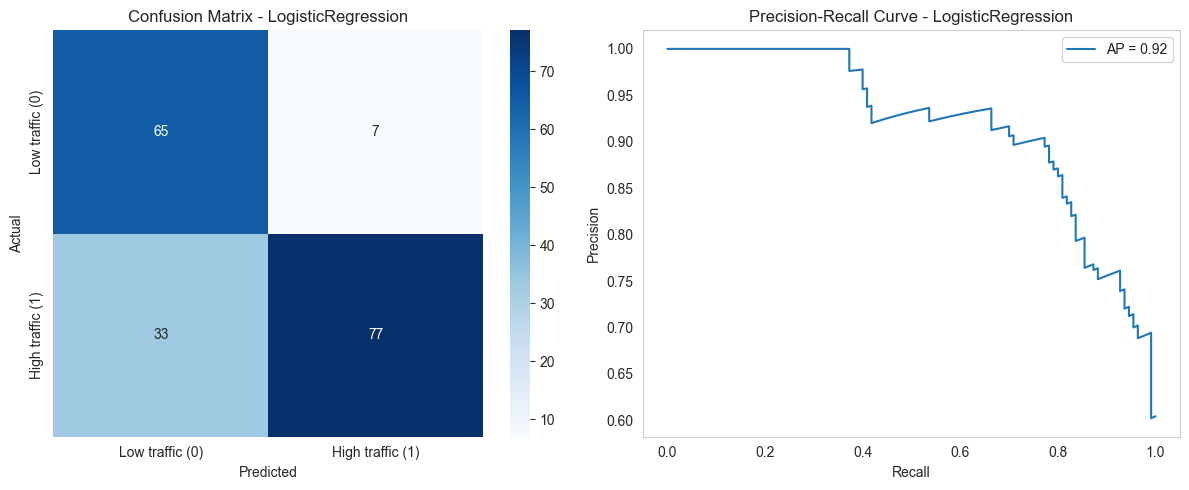

🏃 View run Basic model: LogisticRegression at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/c77b5a8575134f67be22fd1d01031656
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


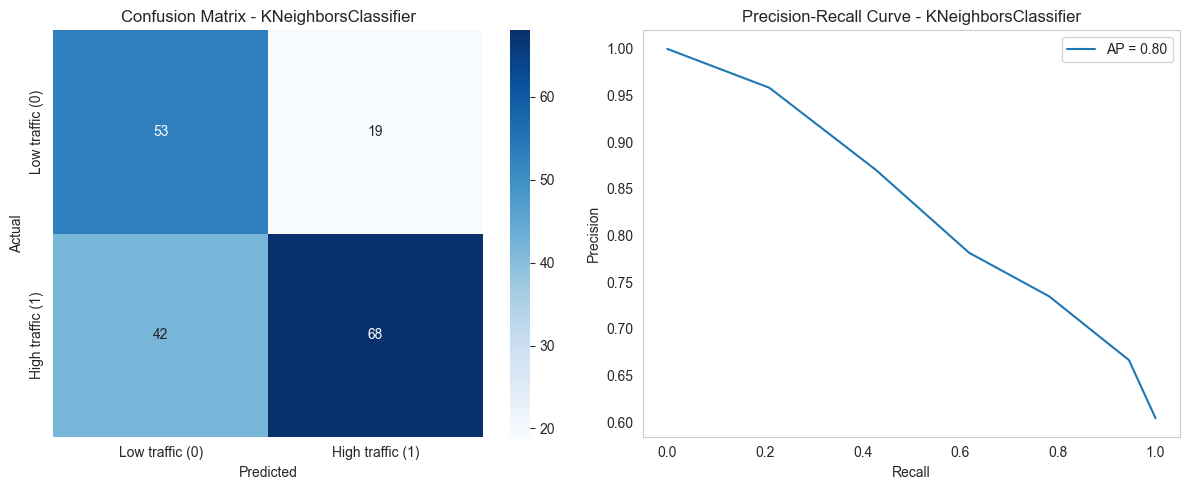

🏃 View run Basic model: KNeighborsClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/a92ffefda8654daea8313ad330546ade
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


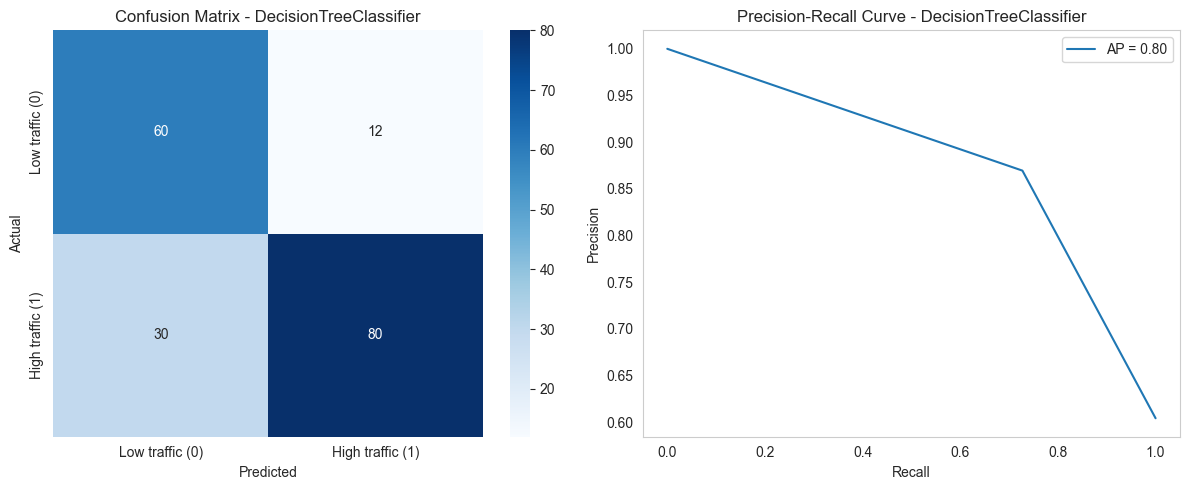

🏃 View run Basic model: DecisionTreeClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/c7606d376c674bddbc7e04663002437d
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


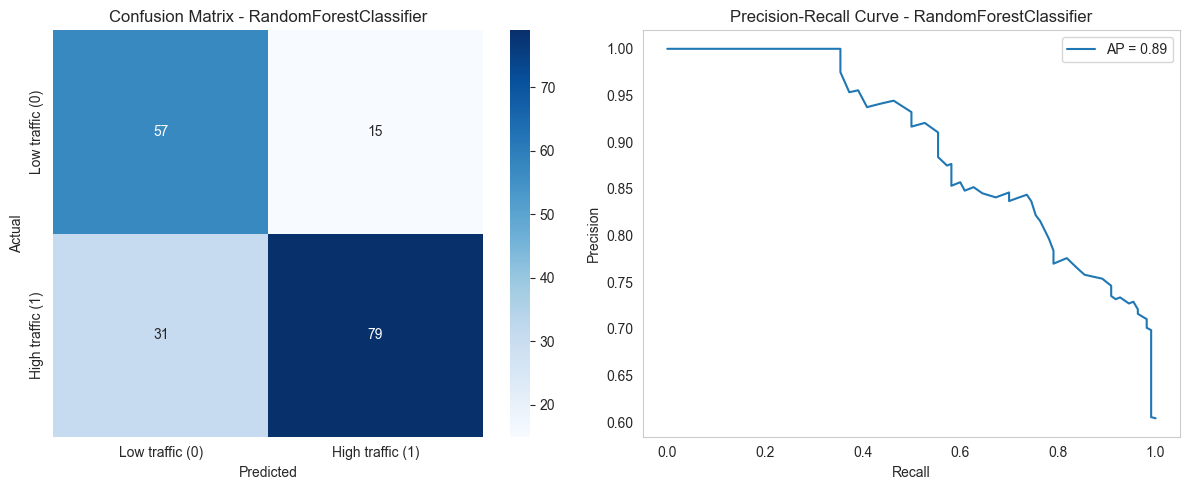

🏃 View run Basic model: RandomForestClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/9a012a6bdbde4fed9c85760a191faadb
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


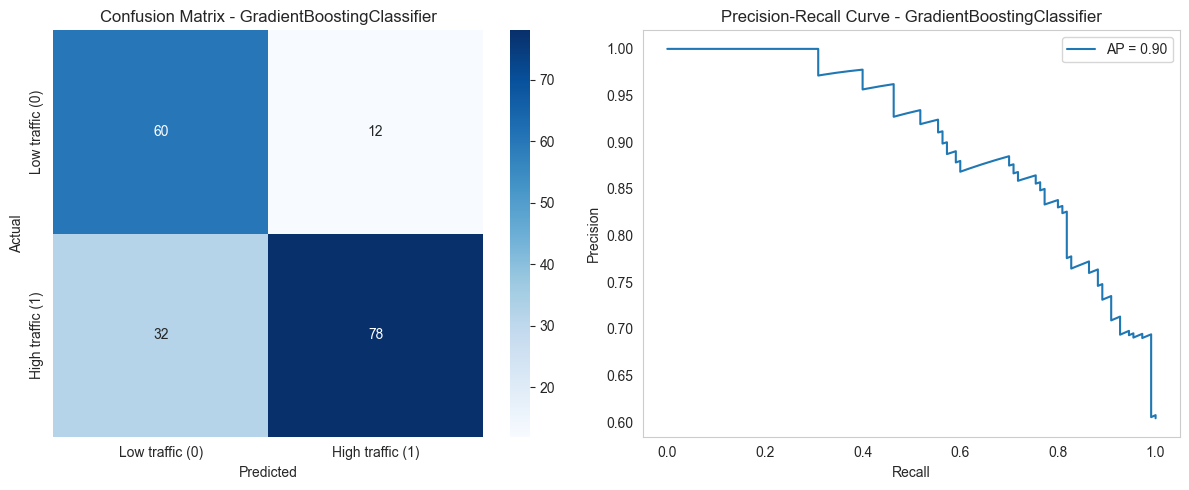

🏃 View run Basic model: GradientBoostingClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/c5fb38097ac848e4b8056a68357e35eb
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


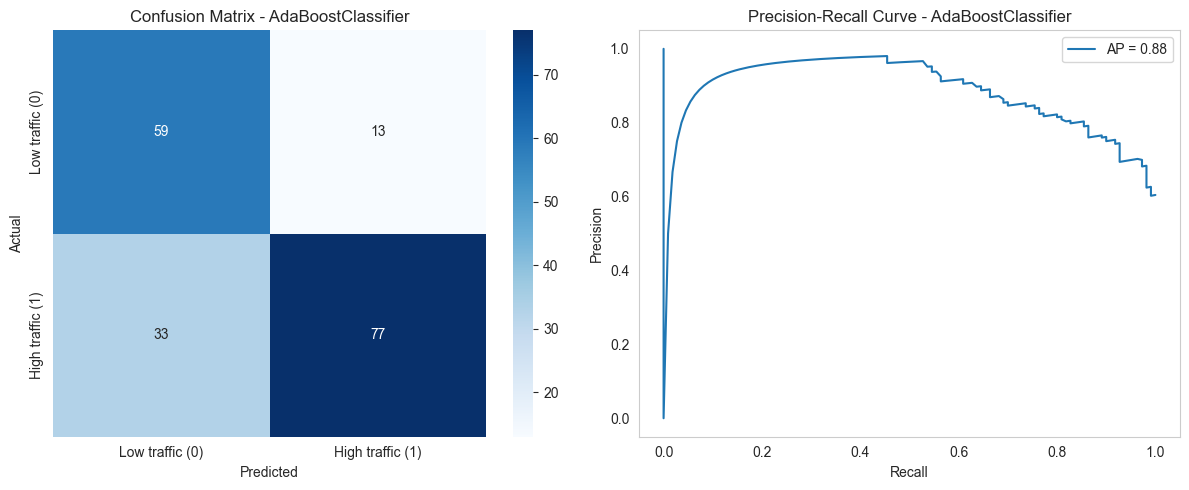

🏃 View run Basic model: AdaBoostClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/7fa62f4079c64a368cdd437c10b475f9
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


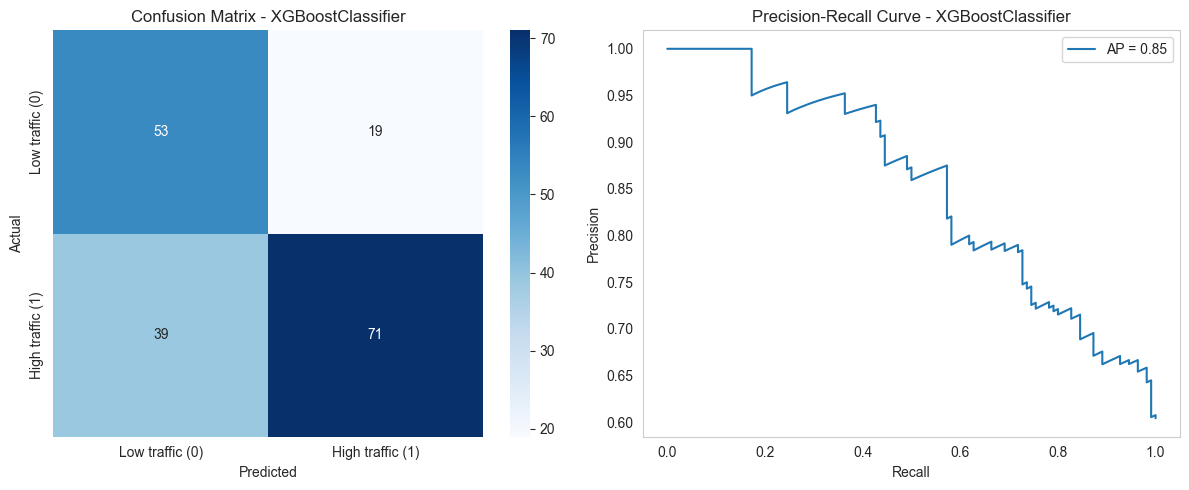

🏃 View run Basic model: XGBoostClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/a58d537714ef44cc9b6e18762c94c5cc
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


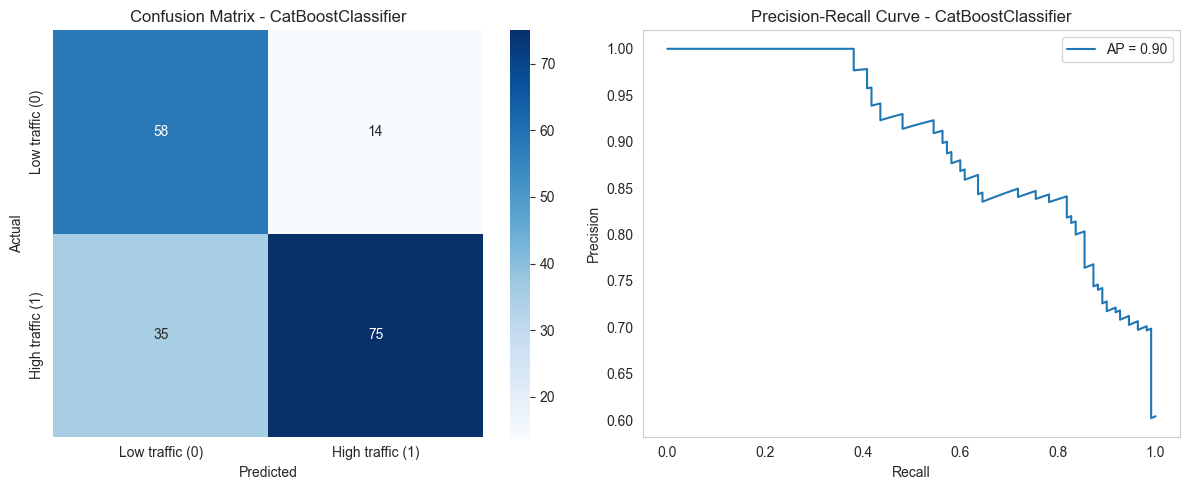

🏃 View run Basic model: CatBoostClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/019cafe7c73c4d3ca376e826590d987f
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


In [ ]:
results_df = evaluate_models(X_train, y_train, X_test, y_test, models, ct)

Models listed by descending precision score on test set

In [ ]:
results_df['test_precision'].sort_values(ascending=False)

model_name
LogisticRegression            0.917
DecisionTreeClassifier        0.870
GradientBoostingClassifier    0.867
AdaBoostClassifier            0.856
CatBoostClassifier            0.843
RandomForestClassifier        0.840
XGBoostClassifier             0.789
KNeighborsClassifier          0.782
Name: test_precision, dtype: float64

Models listed by descending fbeta score with beta=0.5. It means that precision has double of the weight than recall

In [ ]:
results_df['test_f0.5'].sort_values(ascending=False)

model_name
LogisticRegression            0.863
DecisionTreeClassifier        0.837
GradientBoostingClassifier    0.830
AdaBoostClassifier            0.819
RandomForestClassifier        0.813
CatBoostClassifier            0.805
XGBoostClassifier             0.755
KNeighborsClassifier          0.742
Name: test_f0.5, dtype: float64

Models listed by descending average precision score. It shows an overall precision-recall balance at different thresholds

In [ ]:
results_df['test_avg_precision'].sort_values(ascending=False)

model_name
LogisticRegression            0.919
GradientBoostingClassifier    0.904
CatBoostClassifier            0.902
RandomForestClassifier        0.895
AdaBoostClassifier            0.881
XGBoostClassifier             0.853
KNeighborsClassifier          0.802
DecisionTreeClassifier        0.797
Name: test_avg_precision, dtype: float64

#### Picking top 3 baseline models based on fbeta_score

Because of computational limitations I only tune the top 3 best performing models

In [ ]:
top_3_base_models = results_df['test_f0.5'].sort_values(ascending=False).nlargest(3).index.values.tolist()

top_3_base_models

['LogisticRegression', 'DecisionTreeClassifier', 'GradientBoostingClassifier']

#### Plotting features importances for the top 3 models

In [ ]:
sns.set_style('whitegrid')
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

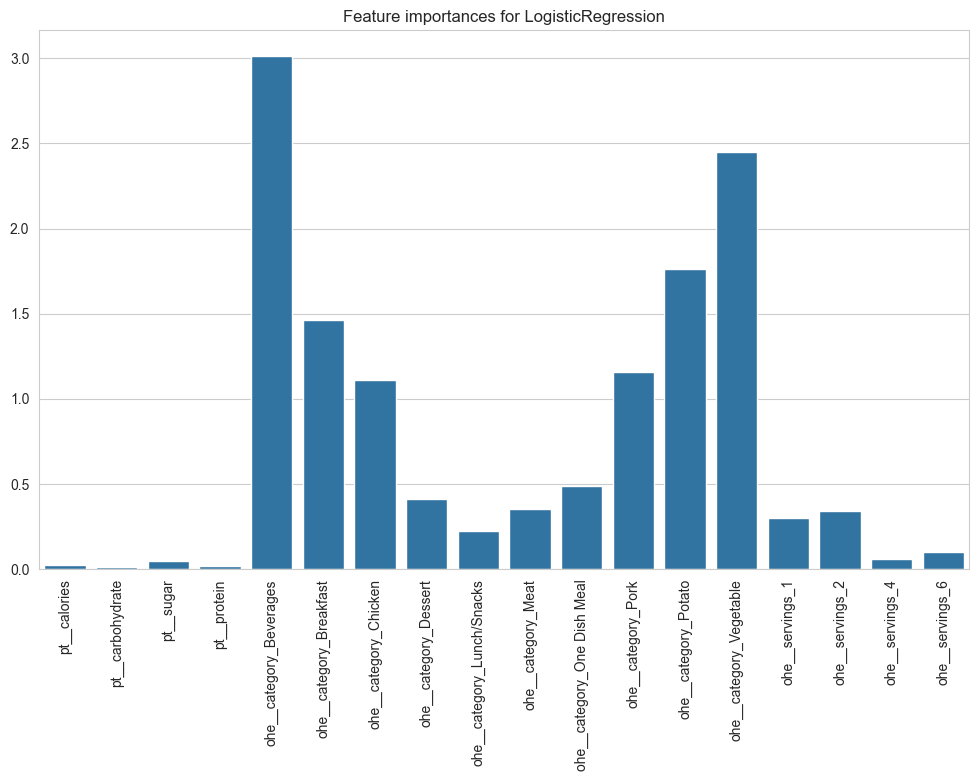

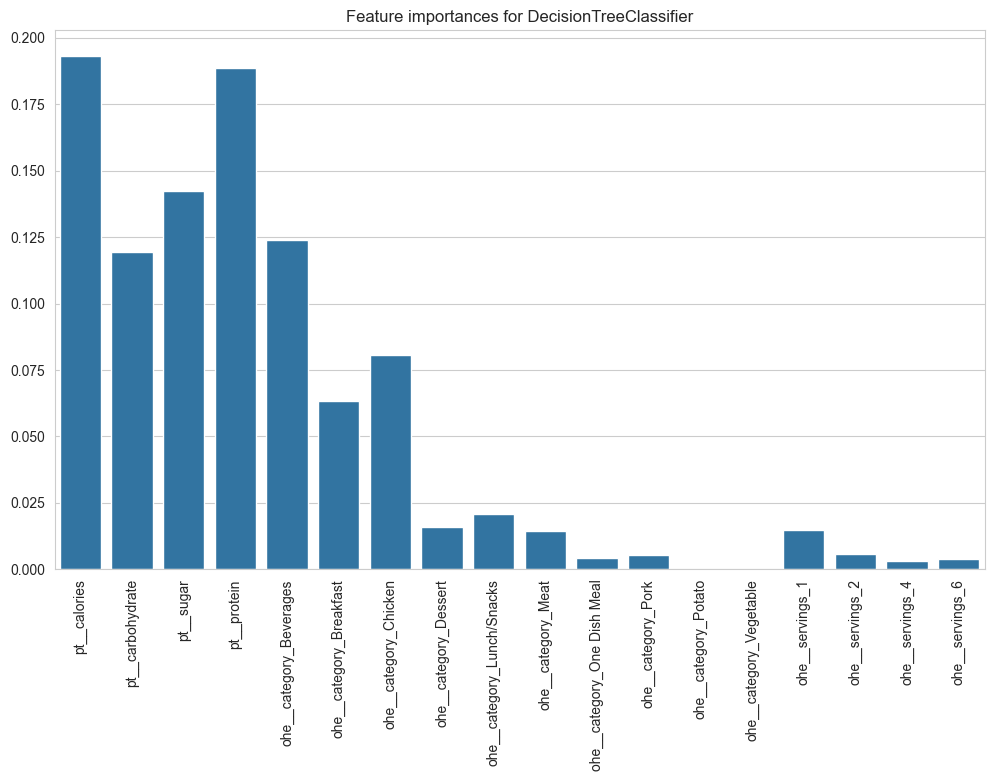

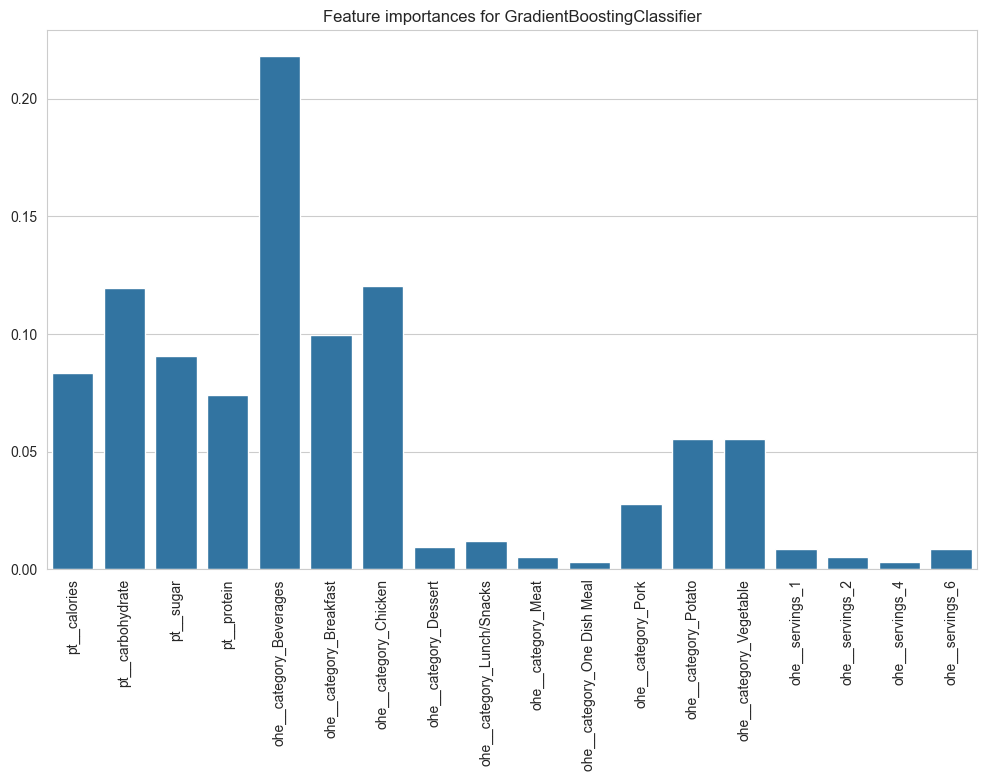

In [ ]:
for model_name, model in models.items():
    
    if model_name in top_3_base_models:
    
        if model_name == 'LogisticRegression':

            pipe = ImbPipeline(steps=[("ct", ct), ('smote', SMOTE(random_state=42)),('model', model)])
            pipe.fit(X_train, y_train)
            
            importances_series = pd.Series(abs(pipe.named_steps["model"].coef_[0]), index=pipe.named_steps['ct'].get_feature_names_out())
        else:
            pipe = Pipeline(steps=[("ct", ct),('model', model)])
            pipe.fit(X_train, y_train)
    
            importances_series = pd.Series(pipe.named_steps['model'].feature_importances_, index=pipe.named_steps['ct'].get_feature_names_out())
            
        fig, ax = plt.subplots(figsize=(12,7))
        sns.barplot(importances_series)
        plt.title(f"Feature importances for {model_name}")
        plt.xticks(rotation=90)
        plt.show()

Tree based models rely heavily on numerical features, while LogisticRegression relies on the category column.
The difference can be attributed to the fact that LogisticRegression captures linear relationships while tree based models capture non-linear relationships.

We have a small amount of features in the dataset but feature selection could be performed with minimal amount of performance loss

#### Setting up hyperparameters to try for the top 3 models

Some parameters are commented out because of computational limitations

In [ ]:
params = {
    "LogisticRegression": [
        {
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs', 'liblinear'],
            'model__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        },
        {
            'model__penalty': ['l1'],
            'model__solver': ['liblinear', 'saga'],
            'model__C': [0.001, 0.01, 0.1, 1.0, 10.0],
        },
        {
            'model__penalty': ['elasticnet'],
            'model__solver': ['saga'],
            'model__C': [0.01, 0.1, 1.0, 10.0],
            'model__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
        }
    ],

    "GradientBoostingClassifier": {
        'model__loss': ['log_loss'],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__n_estimators': [50, 100, 150, 200],
        'model__max_depth': [3, 4, 5, 7],
        #'model__min_samples_split': [2, 5, 10],
        #'model__min_samples_leaf': [1, 2, 4],
        #'model__max_features': ['sqrt', 'log2', None],
        'model__criterion': ['friedman_mse', 'squared_error']
    },

    "DecisionTreeClassifier": {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None],
    'model__class_weight': [None, 'balanced']
}
        }

#### The hyperparameter_tuning function finds the best hyperparameters to apply for the provided models

Creating fbeta_scorer as it is not built-in in GridSearchCV

In [ ]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test, models, top_models, column_transformer, params={}):
    report = []
    best_model_name = None
    best_model = None
    best_params = None
    best_score = 0
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        
        if model_name in top_models:
            param = params.get(model_name, {})
            
            with mlflow.start_run(run_name=f"Tuned model: {model_name}"):
                                    
                pipe_with_sampling = ImbPipeline(steps=[("ct", column_transformer), ('smote', SMOTE(random_state=42)),('model', model)])
                
                grid = GridSearchCV(pipe_with_sampling, param, cv=skf, n_jobs=-1, scoring='precision')
                grid.fit(X_train, y_train)
                
                y_train_pred = grid.best_estimator_.predict(X_train)
                y_test_pred = grid.best_estimator_.predict(X_test)
                y_train_probs = grid.best_estimator_.predict_proba(X_train)[:, 1]
                y_test_probs = grid.best_estimator_.predict_proba(X_test)[:, 1]
            
                
                        
                fig, ax = plt.subplots(1, 2, figsize=(12, 5))
                sns.heatmap(confusion_matrix(y_test, y_test_pred), fmt='d', annot=True, cmap='Blues', ax=ax[0], xticklabels=['Low traffic (0)', 'High traffic (1)'], yticklabels=['Low traffic (0)', 'High traffic (1)'])
                ax[0].set_title(f"Confusion Matrix - {model_name}")
                ax[0].set_xlabel("Predicted")
                ax[0].set_ylabel("Actual")

                precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
                avg_prec = average_precision_score(y_test, y_test_probs)

                ax[1].plot(recall, precision, label=f"AP = {avg_prec:.2f}")
                ax[1].set_title(f"Precision-Recall Curve - {model_name}")
                ax[1].set_xlabel("Recall")
                ax[1].set_ylabel("Precision")
                ax[1].legend()
                ax[1].grid()

                plt.tight_layout()
                plt.show()
                
                
                train_metrics = get_scores(y_train, y_train_pred, y_train_probs, mode="train")
                test_metrics = get_scores(y_test, y_test_pred, y_test_probs, mode="test")
            
                log_metrics_in_mlflow(train_metrics)
                log_metrics_in_mlflow(test_metrics)
            
                mlflow.log_params(grid.best_params_)
                mlflow.set_tag("model description", f"{model_name} with tuned parameters")
            
                scores = {
                "model_name": model_name,
                **train_metrics,
                **test_metrics
                }
                
                if scores['test_f0.5'] > best_score:
                    best_score = scores['test_f0.5']
                    best_model_name = model_name
                    best_model = grid.best_estimator_
                    best_params = grid.best_params_
                    
                report.append(scores)
            

    results_df = pd.DataFrame(report).set_index("model_name").round(2)
    print(f"Best model is: {best_model_name} with an f-beta (0.5) score of: {best_score:.3f}")
    
    return best_model_name, best_model, best_params, results_df

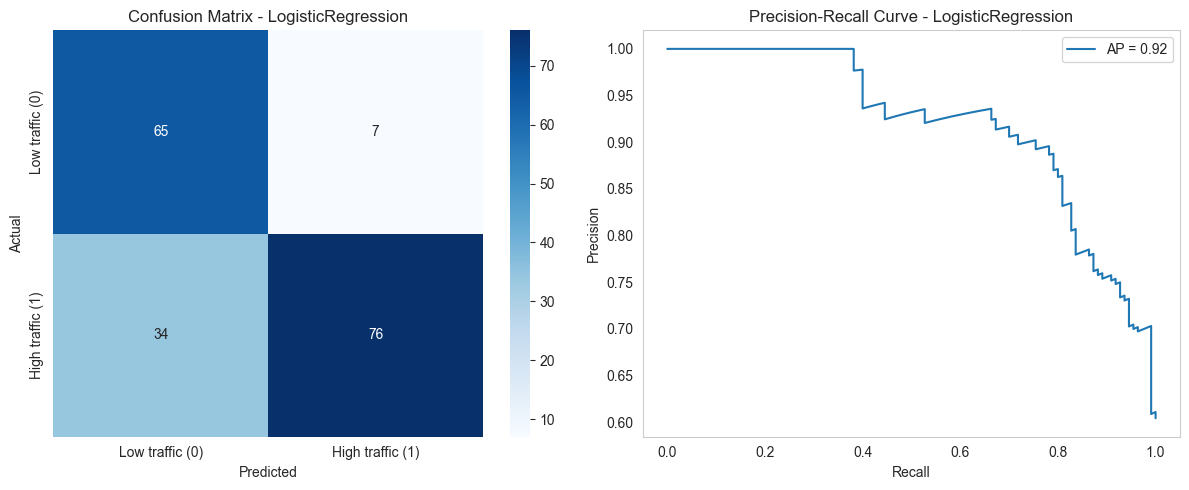

🏃 View run Tuned model: LogisticRegression at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/36191e48e5d24333b4fd360ae4232d3e
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


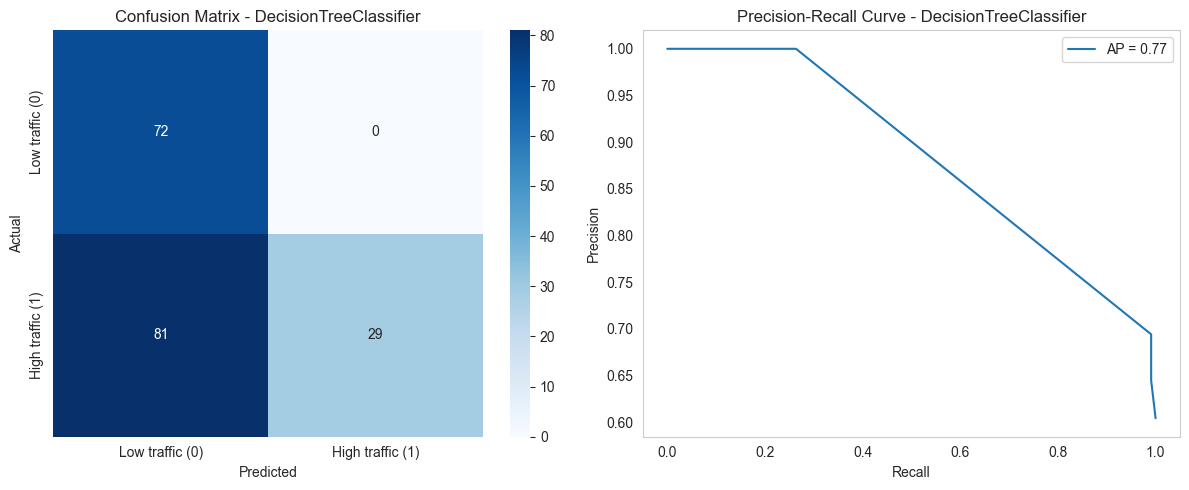

🏃 View run Tuned model: DecisionTreeClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/40b7374b41c446b19168564b0f7caad1
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


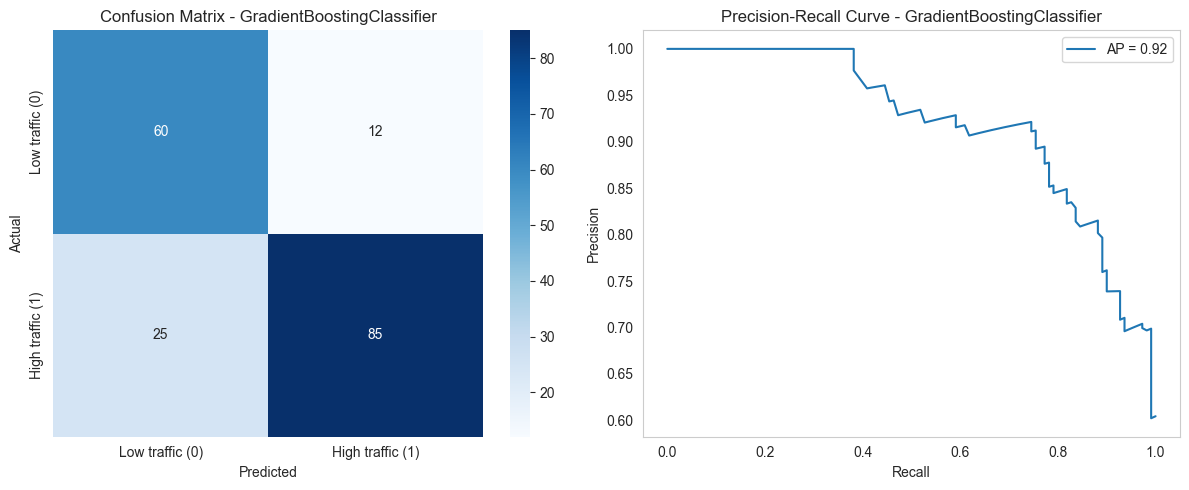

🏃 View run Tuned model: GradientBoostingClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/afc8236a3bb44b2888ed258fe72e2afb
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0
Best model is: LogisticRegression with an f-beta (0.5) score of: 0.860
Best model: LogisticRegression
Best params: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [ ]:
best_model_name, best_model, best_params, results_df = hyperparameter_tuning(X_train, y_train, X_test, y_test, models, top_3_base_models, ct, params)

print(f"Best model: {best_model_name}")
print(f"Best params: {best_params}")

### Taking a look at the results

- DecisionTreeClassifier has perfect precision (1.0), but the F0.5 score is quite low (0.642). That means recall is very poor — it’s missing too many positives.
- GradientBoostingClassifier is close but slightly behind LogisticRegression in both metrics.
- LogisticRegression has the highest F0.5 score (0.86) and good precision (0.916). So it balances precision and recall the best.

In [ ]:
results_df[['test_f0.5', 'test_precision']].sort_values(by='test_f0.5', ascending=False)

,test_f0.5,test_precision
model_name,,
LogisticRegression,0.86,0.92
GradientBoostingClassifier,0.85,0.88
DecisionTreeClassifier,0.64,1.00


# Conclusion

GradientBoostingClassifier and LogisticRegression were already quite close to each other on the baseline models, I focused on the fbeta_score metric which doesn't let the model to predict all recipes to 'High' because it balances the result with recall.
Even though the GradientBoostingClassifier is more robust to outliers and has still good interpretability, the Final model is LogisticRegression because of significantly shorter training time and very good interpretability.

### Saving the model

In [ ]:
best_model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('pt', PowerTransformer(),
                                                  ['calories', 'carbohydrate',
                                                   'sugar', 'protein']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'servings'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(C=10.0, random_state=42))])

In [ ]:
dir_path = os.path.join(os.getcwd(),'models')

os.makedirs(dir_path, exist_ok=True)

joblib.dump(best_model,os.path.join(dir_path,"best_model.joblib"))

print(f"Best model saved to: {dir_path}")

Best model saved to: h:\recipe_site_traffic_classification\notebooks\models
